In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

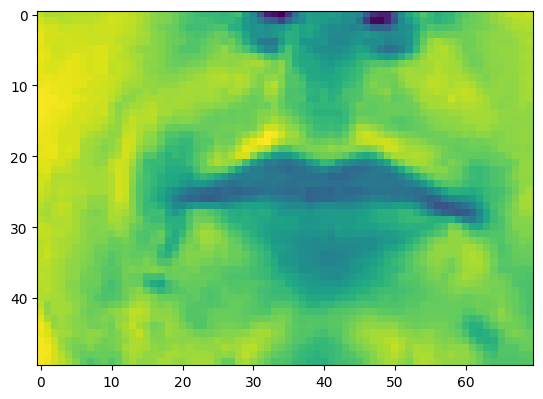

In [33]:
# def load_video(path:str) -> List[float]: 
#     cap = cv2.VideoCapture(path)
#     frames = []
#     for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
#         ret, frame = cap.read()
#         if not ret:
#             continue
#         window = frame[150:230,110:215,:]
#         frame = cv2.cvtColor(window, cv2.COLOR_BGR2frame)
#         frame = tf.expand_dims(frame, axis=-1)
#         # print(frame.shape)
#         frames.append(frame)
#         # frame = tf.image.rgb_to_framescale(frame)
#         # frames.append(frame[180:250,110:215,:])
#     cap.release()
    
#     mean = tf.math.reduce_mean(frames)
#     std = tf.math.reduce_std(tf.cast(frames, tf.float32))
#     return tf.cast((frames - mean), tf.float32) / std




# https://github.com/skaws2003/Dlib-lip-detection/tree/master

import cv2
import dlib

def load_video(path:str) -> List[float]: 
    hog_face_detector = dlib.get_frontal_face_detector()
    dlib_facelandmark = dlib.shape_predictor("./detector/shape_predictor_68_face_landmarks.dat")

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        if not ret:
            continue
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = hog_face_detector(frame)

        for face in faces:
            face_landmarks = dlib_facelandmark(frame, face)
            # for n in range(0, 68):
            #     x = face_landmarks.part(n).x
            #     y = face_landmarks.part(n).y
            #     cv2.circle(frame, (x, y), 1, (0, 0, 255), -1)
            x67 = face_landmarks.part(67).x
            y67 = face_landmarks.part(67).y
            horizontal_padding = 35
            vertical_padding = 25
            lip_window = frame[y67-vertical_padding:y67+vertical_padding, x67-horizontal_padding:x67+horizontal_padding]
            # lip_window = tf.expand_dims(lip_window, axis=-1)
            
        frames.append(lip_window)
    cap.release()
    # return frames
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std



test_path = './dataset/videos/s1/bbaf3s.mpg'
test_path = './dataset/videos/s2/bbaf2s.mpg'
test_path = './dataset/videos/s3/bbal6p.mpg'
# test_path = './data/person0/clips/clip0.mp4'
frm = load_video(test_path)

plt.imshow(frm[20])

In [ ]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [ ]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} \n"
    f"(size ={char_to_num.vocabulary_size()})"
)

In [ ]:
char_to_num([' ','a', 'b', 'c', 'e', 'g', 'i'])

In [ ]:
num_to_char([14,  9,  3, 11, 13])

In [ ]:
def load_alignments(path: str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens, ' ', line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [ ]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    file_name = os.path.splitext(os.path.basename(path))[0]
    subdirectory = os.path.basename(os.path.dirname(path))
    # print(f'path: {path}')
    # print(f'file_name: {file_name}')
    # print(f'subdirectory: {subdirectory}')

    video_path = os.path.join('dataset', 'videos', subdirectory, file_name + '.mpg')  # Adjust extension if needed
    alignment_path = os.path.join('dataset', 'alignments', subdirectory, file_name + '.align')

    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [ ]:
# for windows
# test_path = '.\\data\\person0\\clips\\clip0.mp4'
# test_path = './data/person0/clips/clip0.mp4'
test_path = './dataset/videos/s2/bbaf1n.mpg'

In [ ]:
# for windows
# tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

In [ ]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))
# load_data(tf.convert_to_tensor(test_path))

In [ ]:
plt.imshow(frames[15])
# frames[23]

In [ ]:
# tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])
print([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

In [ ]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# Data Pipeline

In [ ]:
# # for windows
# # data = tf.data.Dataset.list_files('.\\data\\person0\\clips\\*.mp4')
# from glob import glob

# base_directory = './dataset/'
# videos_directory = os.path.join(base_directory, 'videos')
# pattern = os.path.join(videos_directory, '**', '*.mpg')
# files = glob(pattern, recursive=True)

# print(f'Total files: {len(files)}')


# data = tf.data.Dataset.from_tensor_slices(files)
# data = data.shuffle(len(files), reshuffle_each_iteration=False)
# # # NOTE:: split data for train test here

# data = data.map(mappable_function, num_parallel_calls=tf.data.AUTOTUNE)
# data = data.padded_batch(2, padded_shapes=([95,None,None,None],[40]))
# data = data.prefetch(tf.data.AUTOTUNE)

# # train = data.take(450)
# # test = data.skip(450)

# # Calculate sizes for train, validation, and test sets
# train_size = int(0.75 * len(files))
# val_size = int(0.15 * len(files))
# test_size = len(files) - train_size - val_size

# # Split the data into train, validation, and test sets
# train_data = data.take(train_size)
# val_data = data.skip(train_size).take(val_size)
# test_data = data.skip(train_size + val_size)

# print(f'Train size: {train_size}\nValidation size: {val_size}\nTest size: {test_size}')


In [ ]:
from glob import glob

base_directory = './dataset/'
videos_directory = os.path.join(base_directory, 'videos')
pattern = os.path.join(videos_directory, '**', '*.mpg')
files = glob(pattern, recursive=True)

print(f'Total files: {len(files)}')

# Split the data into train, validation, and test sets
train_size = int(0.86 * len(files))
val_size = int(0.07 * len(files))
test_size = len(files) - train_size - val_size
print(f'Train size: {train_size}\nValidation size: {val_size}\nTest size: {test_size}')

# Split the files list into train, validation, and test sets
train_files = files[:train_size]
val_files = files[train_size:train_size + val_size]
test_files = files[train_size + val_size:]

# Load datasets from file paths
train_data = tf.data.Dataset.from_tensor_slices(train_files)
val_data = tf.data.Dataset.from_tensor_slices(val_files)
test_data = tf.data.Dataset.from_tensor_slices(test_files)

# Shuffle the datasets
train_data = train_data.shuffle(train_size, reshuffle_each_iteration=False)
val_data = val_data.shuffle(val_size, reshuffle_each_iteration=False)
test_data = test_data.shuffle(test_size, reshuffle_each_iteration=False)

# Map preprocessing function and batch the datasets
train_data = train_data.map(mappable_function, num_parallel_calls=tf.data.AUTOTUNE)
val_data = val_data.map(mappable_function, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.map(mappable_function, num_parallel_calls=tf.data.AUTOTUNE)

# Batch the datasets
batch_size = 2
tot_frames = 95
tot_chars = 40
train_data = train_data.padded_batch(batch_size, padded_shapes=([tot_frames, None, None, None], [tot_chars]))
val_data = val_data.padded_batch(batch_size, padded_shapes=([tot_frames, None, None, None], [tot_chars]))
test_data = test_data.padded_batch(batch_size, padded_shapes=([tot_frames, None, None, None], [tot_chars]))

# Prefetch the datasets
train_data = train_data.prefetch(tf.data.AUTOTUNE)
val_data = val_data.prefetch(tf.data.AUTOTUNE)
test_data = test_data.prefetch(tf.data.AUTOTUNE)

In [ ]:
# frames, alignments = data.as_numpy_iterator().next()

In [ ]:
sample = train_data.as_numpy_iterator()
val = sample.next()
print(val[1])

In [ ]:
sample1 = val_data.as_numpy_iterator()
val1 = sample.next()
print(val[1])

In [ ]:
sample2 = test_data.as_numpy_iterator()
val2 = sample.next()
print(val[1])

In [ ]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(val[0][0][20])

In [ ]:
# tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

words = [num_to_char(word) for word in val[1][0]]
joined_words = tf.strings.reduce_join(words).numpy().decode('utf-8')
print(joined_words)

# Design the Deep Neural Network

In [ ]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [ ]:
train_data.as_numpy_iterator().next()[0][0].shape

In [ ]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(95,80,105,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(200, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [ ]:
model.summary()

In [ ]:
model.input_shape

In [ ]:
model.output_shape

# Setup Training Options and Train

In [ ]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [ ]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        
        decoded = tf.keras.backend.ctc_decode(yhat, [95, 95], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*20)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss, metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 

schedule_callback = LearningRateScheduler(scheduler)

example_callback = ProduceExample(val_data)

backup_callback = tf.keras.callbacks.BackupAndRestore(
    "./training_backup",
    save_freq='epoch',
    delete_checkpoint=True,
)

In [ ]:
model.fit(train_data, validation_data=val_data, epochs=100, callbacks=[backup_callback, checkpoint_callback, schedule_callback, example_callback])

# Make Predictions

In [ ]:
# for windows
# model.load_weights('.\\models\\checkpoint')
model.load_weights('./models/checkpoint')

In [ ]:
test_single = test_data.as_numpy_iterator()

In [ ]:
sample = test_single.next()

In [ ]:
yhat = model.predict(sample[0])